In [1]:
!nvidia-smi

Sun Dec  3 17:08:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:01:00.0 Off |                  Off |
| 30%   25C    P8              17W / 230W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Imports 
import torch
import transformers
from datasets import load_dataset
from PIL import Image
import json

"""
Unused imports:
import torch.nn as nn
import bitsandbytes as bnb
"""


from transformers import LlamaForCausalLM, LlamaTokenizer, LlamaForSequenceClassification, BitsAndBytesConfig

from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    prepare_model_for_kbit_training,
    set_peft_model_state_dict,
    get_peft_config, 
    TaskType, 
    PeftType,
    PeftModel
)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /nfshomes/canum05/miniconda3/envs/llm/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so


/nfshomes/canum05/miniconda3/envs/llm/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/nfshomes/canum05/miniconda3/envs/llm/lib/libcudart.so.11.0'), PosixPath('/nfshomes/canum05/miniconda3/envs/llm/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


CUDA SETUP: CUDA runtime path found: /nfshomes/canum05/miniconda3/envs/llm/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /nfshomes/canum05/miniconda3/envs/llm/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


In [12]:
# # Generate combined dataset
# from datasets import load_dataset, concatenate_datasets, Value

# image_dataset = load_dataset("json", data_files="/fs/cml-datasets/coco/annotations/captions_train2017.json", field="images", split = "train")
# image_map = { str(i["id"]): {"file_name": i["file_name"], "coco_url": i["coco_url"]} for i in image_dataset}

# def get_clevr_filepath(filename):
#     return f"~/scratch/data/CLEVR_v1.0/images/val/{filename}"
    
# def get_coco_filepath(filename):
#     return f"/fs/cml-datasets/coco/images/train2017/{filename}"

# def add_coco_image_data(image_map):
#     def _mapper(items):
#         images = [image_map[i] for i in items["image_id"]]
#         items["image_filename"] = [get_coco_filepath(image["file_name"]) for image in images]
#         items["dataset_type"] = ["coco" for _ in images]
#         question = "What do you see in the image?"
#         return {"answer": items["caption"], "image_filepath": items["image_filename"], "question": [question for _ in images]}
#     return _mapper

# def add_coco_qa_image_data(image_map):
#     def _mapper(items):
#         images = [image_map[i] for i in items["image_id"]]
#         items["image_filename"] = [get_coco_filepath(image["file_name"]) for image in images]
#         items["dataset_type"] = ["coco_qa" for _ in images]
#         return {"answer": items["caption"], "image_filepath": items["image_filename"]}
#     return _mapper
    
# def add_clevr_image_data(items):
#     items["image_filename"] = [get_clevr_filepath(i) for i in items["image_filename"]]
#     return {"image_filepath": items["image_filename"], "dataset_type": ["clevr" for i in items["image_filename"]]}


# coco_captions_dataset= load_dataset("json", data_files="/fs/cml-datasets/coco/annotations/captions_train2017.json", field="annotations", split="train").cast_column("image_id", Value(dtype='string', id=None))
# coco_dataset = coco_captions_dataset.map(add_coco_image_data(image_map), batched=True).remove_columns(["caption", "image_id", "id", "image_filename"])

# _clevr_dataset = load_dataset("json", data_files="/nfshomes/canum05/scratch/data/CLEVR_v1.0/questions/CLEVR_val_questions.json", field="questions", split="train")
# clevr_dataset = _clevr_dataset.map(add_clevr_image_data, batched=True).remove_columns(["split", "image_index", "program", "question_family_index", "question_index", "image_filename"])

# coco_qa_questions = load_dataset("text", data_files="/nfshomes/canum05/scratch/data//train/questions.txt", split="train").rename_column("text", "question")
# coco_qa_answers = load_dataset("text", data_files="/nfshomes/canum05/scratch/data/train/answers.txt", split="train").rename_column("text", "caption")
# coco_qa_image_ids = load_dataset("text", data_files="/nfshomes/canum05/scratch/data/train/img_ids.txt", split="train").rename_column("text", "image_id")
# _coco_qa_ds = concatenate_datasets([coco_qa_questions, coco_qa_answers, coco_qa_image_ids], axis=1)
# coco_qa_dataset = _coco_qa_ds.map(add_coco_qa_image_data(image_map), batched=True).remove_columns(["caption", "image_id", "image_filename"])

# # Generate test train split and combine
# coco_split = coco_dataset.train_test_split(test_size=0.2)
# coco_qa_split = coco_qa_dataset.train_test_split(test_size=0.2)
# clevr_split = clevr_dataset.train_test_split(test_size=0.2)
# train_ds = concatenate_datasets([ coco_split['train'], clevr_split["train"], coco_qa_split["train"]]).shuffle()
# test_ds = concatenate_datasets([coco_split["test"], clevr_split["test"], coco_split["test"]]).shuffle()

# # Save dataset
# train_ds.to_json("./dataset/combined-40k-train.json")
# test_ds.to_json("./dataset/combined-40k-test.json")

In [70]:
X_train = load_dataset("json", data_files="./dataset/combined-40k-train.json", split="train")
X_test = load_dataset("json", data_files="./dataset/combined-40k-test.json", split="train")

Found cached dataset json (/fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-0a0918c9c768ebd3/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
Found cached dataset json (/fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-1e2729444f2596b4/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [71]:
len(X_train)

656382

In [72]:
len(X_train), len(X_test)


(656382, 266701)

In [73]:
X_train = X_train.shuffle(seed=42)

Loading cached shuffled indices for dataset at /fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-0a0918c9c768ebd3/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-5784596ee99707b7.arrow


In [74]:
from datasets import Dataset
from collections import Counter

# Assuming X_train is a list of dictionaries
dataset_types = [example['dataset_type'] for example in X_train]

# Count the occurrences of each dataset type
dataset_type_counts = Counter(dataset_types)

# Select a balanced count of each dataset type
balanced_count = 23000

# Function to filter examples for a specific dataset type
def filter_dataset_type(dataset, dataset_type, count):
    return dataset.filter(lambda example: example['dataset_type'] == dataset_type).select(list(range(count)))

# List to store balanced datasets
balanced_datasets = []

# Iterate over unique dataset types
for dataset_type in dataset_type_counts.keys():
    # Filter and select a balanced count of examples for each dataset type
    balanced_dataset = filter_dataset_type(X_train, dataset_type, balanced_count)
    balanced_datasets.append(balanced_dataset)

# Combine balanced datasets into a single dataset
X_train_balanced = Dataset.from_dict({
    key: sum([dataset[key] for dataset in balanced_datasets], [])
    for key in balanced_datasets[0].column_names
})

# Check the length of the balanced dataset
print(len(X_train_balanced))


Loading cached processed dataset at /fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-0a0918c9c768ebd3/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-8ae2543ac1e53dd7.arrow
Loading cached processed dataset at /fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-0a0918c9c768ebd3/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-33fc0cca21cf9fc3.arrow
Loading cached processed dataset at /fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-0a0918c9c768ebd3/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-1015691d1c9a463f.arrow


69000


In [75]:
X_train = X_train_balanced

In [76]:
img_tokens = [f"[IMG-{i}]" for i in range(1, 198)]

In [77]:
# device_map = {"": 0}
device_map = "auto"

base_model = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model, use_fast=False)
tokenizer.add_special_tokens(
    {
     
        "pad_token": "<PAD>",
    }
)


special_tokens_dict = {'additional_special_tokens': img_tokens}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model = LlamaForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    device_map=device_map,
    use_auth_token=True
)
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding(32198, 4096)

In [78]:
# import torch
# import torch.nn as nn
# from transformers import Blip2QFormerConfig, Blip2QFormerModel

# class QFormer(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.qformer_config = Blip2QFormerConfig(
#             encoder_hidden_size=768
#         )
#         self.qformer = Blip2QFormerModel(self.qformer_config).to(0)
#         self.query_tokens = nn.Parameter(
#             torch.zeros(1, 32, 768)
#         )
#         self.query_tokens.data.normal_(mean=0.0, std=0.02)

#     def forward(self, img_embeddings):
#         query_tokens = self.query_tokens.expand(img_embeddings.shape[0], -1, -1)
#         image_atts = torch.ones(img_embeddings.size()[:-1], dtype=torch.long).to(0)
#         qformer_embeddings = self.qformer(
#             query_embeds=query_tokens.to(0), 
#             encoder_hidden_states=img_embeddings.to(0),
#             encoder_attention_mask=image_atts.to(0),
#             return_dict=True
#         )
#         return qformer_embeddings

In [79]:
# import torch.nn as nn
# qformer = QFormer()

In [80]:
X_train[20]

{'dataset_type': 'coco',
 'answer': 'A person on skis on a road by a tree.',
 'image_filepath': '/fs/cml-datasets/coco/images/train2017/000000448131.jpg',
 'question': 'What do you see in the image?'}

In [81]:
img_token_id = tokenizer("[IMG-1]", add_special_tokens=False)["input_ids"][0]
img_token_id

32001

In [82]:
X_train[-134]

{'dataset_type': 'clevr',
 'answer': 'yes',
 'image_filepath': '~/scratch/data/CLEVR_v1.0/images/val/CLEVR_val_001180.png',
 'question': 'Does the green object have the same material as the large thing to the right of the large green rubber object?'}

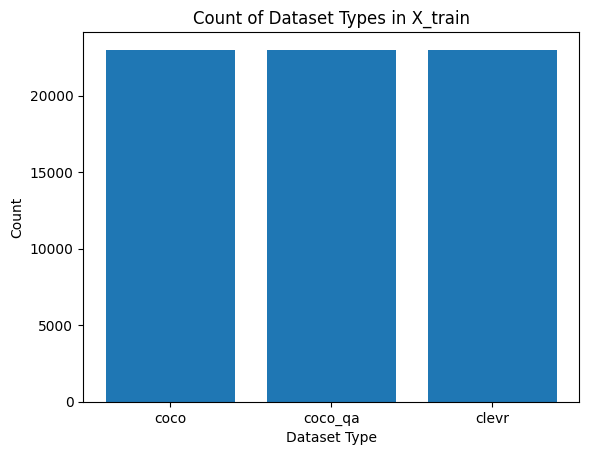

In [83]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming X_train is a list of dictionaries
dataset_types = [example['dataset_type'] for example in X_train]

# Count the occurrences of each dataset type
dataset_type_counts = Counter(dataset_types)

# Extract data for plotting
labels, counts = zip(*dataset_type_counts.items())

# Create a bar plot
plt.bar(labels, counts)
plt.xlabel('Dataset Type')
plt.ylabel('Count')
plt.title('Count of Dataset Types in X_train')
plt.show()

In [84]:
from torch.utils.data import Dataset, DataLoader

# [IMG] = 32001

system_instruction = "You are a helpful AI assistant that can understand what is going on in an image and respond accordingly."
llama2_prompt = """<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

{user_message} [/INST]"""

class VQADataset(Dataset):
    def __init__(self, ds, tokenizer, cutoff_len=350):
        self.ds = ds
        self.tokenizer = tokenizer
        self.cutoff_len = cutoff_len

    def __len__(self):
        return len(self.ds)

    def tokenize(self, prompt, add_eos_token=False, padding=True):
        # there's probably a way to do this with the tokenizer settings
        # but again, gotta move fast
        if padding:
            result = self.tokenizer(
                prompt,
                truncation=True,
                max_length=self.cutoff_len,
                padding="max_length",
                return_tensors=None,
            )
        else:
            result = self.tokenizer(
                prompt,
                truncation=True,
                max_length=self.cutoff_len,
                padding=False,
                return_tensors=None,
            )
        if (
            result["input_ids"][-1] != tokenizer.eos_token_id
            and len(result["input_ids"]) < self.cutoff_len
            and add_eos_token
        ):
            result["input_ids"].append(tokenizer.eos_token_id)
            result["attention_mask"].append(1)

        result["labels"] = result["input_ids"].copy()

        return result
        
    def __getitem__(self, idx):
        item = self.ds[idx]
        image_path = item["image_filepath"]
        q = item["question"]
        a = item["answer"]
        img_placeholder = "".join(img_tokens)
        prefix = """<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

Based on the following image {img_placeholder}, answer the following question.""".format(system_prompt=system_instruction, img_placeholder=img_placeholder)
        question = f"QUESTION: {q} [/INST]"
        answer = f"ANSWER: {a}</s>"
        
        full_prompt = f"{prefix}\n{question}{answer}"
        user_prompt = f"{prefix}\n{question}"
        tokenized_full_prompt = self.tokenize(full_prompt)
        img_token_position = tokenized_full_prompt["input_ids"].index(img_token_id)
        
        tokenized_user_prompt = self.tokenize(user_prompt, padding=False)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        tokenized_full_prompt["labels"] = [
                -100
            ] * user_prompt_len + tokenized_full_prompt["labels"][
                user_prompt_len:
            ]  # could be sped up, probably
        
        return {
            "input_ids": torch.tensor(tokenized_full_prompt["input_ids"]).reshape(1, -1),
            "attention_mask": torch.tensor(tokenized_full_prompt["attention_mask"]).reshape(1, -1),
            "labels": torch.tensor(tokenized_full_prompt["labels"]).reshape(1, -1),
            # "user_prompt_tokens": self.tokenize(f"{user_prompt} [/INST]"),
             "question": q,
             "answer": a,
            "image_path": image_path,
            "img_token_position": img_token_position,
            "user_prompt_len": user_prompt_len,
            # "full_prompt": full_prompt,
             "user_prompt": user_prompt
        }



In [85]:
len(X_train)

69000

In [86]:
cutoff_len = 350
train_ds = VQADataset(X_train, tokenizer, cutoff_len)
test_ds = VQADataset(X_test, tokenizer, cutoff_len)

In [87]:
train_dataloader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=1
)
test_dataloader = DataLoader(
    test_ds,
    batch_size=3,
    shuffle=True,
    num_workers=1
)

In [88]:
# _x = next(enumerate(train_dataloader))

In [89]:
# _x[1]["img_token_position"][0]

In [90]:
# Load ViT + LoRA
from transformers import AutoImageProcessor, ViTModel

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
device_map_vit = {"": 1}
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", device_map=device_map_vit)
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.2,
    bias="all",
)
vit = get_peft_model(vit, config)
vit.print_trainable_parameters()

trainable params: 988,416 || all params: 87,273,984 || trainable%: 1.1325436913708442


In [91]:
import torch.nn as nn
vit_to_llm = nn.Linear(768, 4096).to(1)

# vit_to_llm = nn.Sequential(
#     nn.Linear(768, 2048),  
#     nn.ReLU(),  
#     nn.Dropout(0.1),
#     nn.Linear(2048, 2048), 
#     nn.ReLU(),  
#     nn.Dropout(0.1),
#     nn.Linear(2048, 4096)
# ).to(0)

In [92]:
W = vit_to_llm

In [93]:
# Before training
_before = list(W.parameters())[:25]
_before

[Parameter containing:
 tensor([[-0.0075, -0.0148, -0.0341,  ..., -0.0358, -0.0326, -0.0035],
         [ 0.0008, -0.0161, -0.0001,  ...,  0.0246, -0.0216,  0.0210],
         [-0.0302, -0.0331,  0.0019,  ..., -0.0127,  0.0189,  0.0046],
         ...,
         [ 0.0156, -0.0047, -0.0354,  ...,  0.0184,  0.0243, -0.0212],
         [-0.0004, -0.0080,  0.0311,  ...,  0.0151, -0.0162,  0.0045],
         [-0.0136, -0.0196,  0.0337,  ...,  0.0175, -0.0119, -0.0103]],
        device='cuda:1', requires_grad=True),
 Parameter containing:
 tensor([-2.7687e-02,  1.3336e-02, -1.1237e-02,  ..., -2.2709e-02,
         -9.6274e-05, -3.3283e-02], device='cuda:1', requires_grad=True)]

In [94]:
import gc
gc.collect()

0

In [95]:
from ipywidgets import FloatProgress
from tqdm.auto import tqdm
from tqdm.auto import tqdm as tqdm_auto
from torch.optim import AdamW, Adam
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import random
from torch.autograd import Variable
from itertools import chain
import os

lr = 1e-4

params = chain(
    vit.parameters(),
    vit_to_llm.parameters()
)

optimizer = Adam(params=params, lr=lr)
checkpoint_dir = "./Data/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
losses_total = []

grads_total = []

num_epochs = 3

total_loss = 0
count = 1

for epoch in tqdm_auto(range(num_epochs), desc='Epochs', leave=False):
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True) as t:
      t.set_description('Training loop')
      for i, batch in enumerate(t):
          gc.collect()
          first_img_token_position = batch["img_token_position"][0]
          labels = batch["labels"].squeeze(1)
          img_paths = [p for p in batch["image_path"]]
          img_paths = [p.replace("~/scratch/data/CLEVR_v1.0/images", "/nfshomes/canum05/scratch/data/CLEVR_v1.0/images") for p in img_paths]
          images = [Image.open(p).convert("RGB") for p in img_paths]
          processed_images = [image_processor(img, return_tensors="pt").to(1) for img in images]
          vit_outs = [vit(**inputs) for inputs in processed_images]
          last_hidden = [outputs.last_hidden_state for outputs in vit_outs]
          
          img_embeddings = torch.cat([h for h in last_hidden], dim=0)
          mapped_img_embeddings = vit_to_llm(img_embeddings)
          attn_mask = batch["attention_mask"].squeeze(1)
          ins_embeddings = model.model.embed_tokens(batch["input_ids"].to(0)).squeeze(1)
          input_embeds = torch.cat([
              ins_embeddings[:, :first_img_token_position, :].to(model.device),
              mapped_img_embeddings.to(model.device), 
              ins_embeddings[:, first_img_token_position + 197:, :].to(0)], dim=1
          )
          
          out = model(inputs_embeds=input_embeds.half(), attention_mask=attn_mask, labels=labels)
          loss = out.loss
          total_loss += loss.item()
          avg_loss = total_loss / count
          t.set_postfix(loss=avg_loss)
          count += 1
          loss.backward()
          # loss.backward(retain_graph=True)
                         
          # grads_loss= torch.autograd.grad(loss, W.parameters(), retain_graph=True, create_graph=True)
          # grad_norm = torch.norm(grads_loss[0], 2)
          # grads_total.append(grad_norm)
          optimizer.step()
          optimizer.zero_grad()
          if i % 1000 == 0:
                losses_total.append(loss.item()) 
                checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pt")
                torch.save({
                      'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                    }, checkpoint_path)
                  
    


final_checkpoint_path = os.path.join(checkpoint_dir, "final_checkpoint.pt")
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, final_checkpoint_path)




Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3:   0%|          | 0/17250 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [96]:

vit.save_pretrained("./Data/models/vit-lora_epoch_3/")
torch.save(vit_to_llm.state_dict(), './Data/models/vit-to-llm_epoch_3.pt')

In [1]:
from transformers import AutoImageProcessor, ViTModel

model_id = "./Data/models/vit-lora"
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
device_map_vit = {"": 1}
#vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", device_map=device_map_vit)
# config = LoraConfig(
#     r=32,
#     lora_alpha=32,
#     target_modules=["query", "key", "value"],
#     lora_dropout=0.1,
#     bias="none",
# )
#vit = get_peft_model(vit, config)

#model_config = PeftConfig.from_pretrained()


vit = ViTModel.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    device_map=device_map_vit
)
vit = PeftModel.from_pretrained(vit, model_id)

2023-11-20 16:22:44.942187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10631] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 16:22:44.942248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 16:22:45.444147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1533] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 16:23:03.707887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyboardInterrupt: 

In [2]:
# Load ViT + LoRA
from transformers import AutoImageProcessor, ViTModel

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
device_map_vit = {"": 1}
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", device_map=device_map_vit)
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.2,
    bias="all",
)
vit = PeftModel.from_pretrained(vit, './Data/models/vit-lora')
vit.print_trainable_parameters()

NameError: name 'LoraConfig' is not defined

In [142]:
checkpoint_dir = "./Data/models"
os.makedirs(checkpoint_dir, exist_ok=True)
final_checkpoint_path = os.path.join(checkpoint_dir, "final_checkpoint_2.pt")
torch.save({
    'epoch': 2,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, final_checkpoint_path)

In [143]:
checkpoint_dir = "./Data/models"
os.makedirs(checkpoint_dir, exist_ok=True)
final_checkpoint_path = os.path.join(checkpoint_dir, "vit_to_llm_final_checkpoint_2.pt")
torch.save({
    'epoch': 2,
    'model_state_dict': vit_to_llm.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, final_checkpoint_path)

In [90]:
from transformers import GenerationConfig
temperature=0.1
top_p=0.75
top_k=40
num_beams=4
max_new_tokens=128
generation_config = GenerationConfig(
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    num_beams=num_beams,
    # do_sample=True
)

What do you see in the image?
An older man standing next to a large red truck.


/nfshomes/canum05/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


tensor([[    1,  2190, 23066,  1001, 29901,   319,   767, 13407,  2446,   304,
           263,   534,  2707,   411,   263,  1020,  3955, 10959, 29889,     2]],
       device='cuda:0')


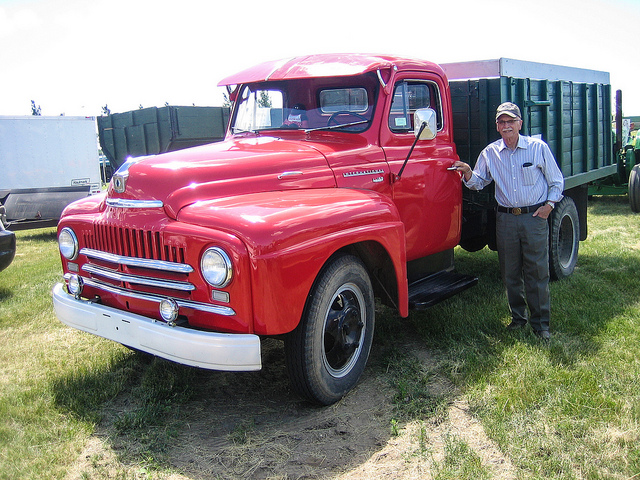

In [97]:


idx = 12811
_c = test_ds[idx]
# print(_c)

question = _c["question"]
answer = _c["answer"]
label = _c["labels"]
user_prompt = _c["user_prompt"]
img_path =  _c["image_path"].replace("~/scratch/data/CLEVR_v1.0/images", "/nfshomes/canum05/scratch/data/CLEVR_v1.0/images")
first_img_token_position = _c["img_token_position"]
img = Image.open(img_path).convert("RGB")

print(question)
print(answer)
# print(user_prompt)

user_prompt_tokens = tokenizer(user_prompt, return_tensors="pt")
processed_image = image_processor(img, return_tensors="pt").to(1)
vit_out = vit(**processed_image)
last_hidden = vit_out.last_hidden_state
mapped_img_embeddings = vit_to_llm(last_hidden)
ins_embeddings = model.model.embed_tokens(user_prompt_tokens["input_ids"].to(0)).squeeze(1)
input_embeds = torch.cat([
              ins_embeddings[:, :first_img_token_position, :].to(model.device),
              mapped_img_embeddings.to(model.device), 
              ins_embeddings[:, first_img_token_position + 197:, :].to(0)], dim=1
          )

# _gen = model.generate(
#     inputs_embeds=input_embeds.half(),
#     generation_config=generation_config,
#     return_dict_in_generate=True,
#     output_scores=True,
#     max_new_tokens=100,
#     bos_token_id=1
# )

_gen = model.generate(
    inputs_embeds=input_embeds.half(),
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=202
)
hs = _gen.hidden_states
seq = _gen.sequences
print(seq)
img

In [98]:
tokenizer.batch_decode(seq, skip_special_tokens=True)

['ANSWER: A man standing next to a truck with a trailer attached.']

In [100]:
X_test[0]

{'dataset_type': 'coco',
 'answer': 'an image of a boy getting a birthday cake',
 'image_filepath': '/fs/cml-datasets/coco/images/train2017/000000300868.jpg',
 'question': 'What do you see in the image?'}

In [119]:
def add_question(item):
    item["question"] = "Name all the colors you see in the image"
    return item

dummy_ds = load_dataset("json", data_files="./dataset/combined-test.json", split="train").shuffle()
dummy_ds = dummy_ds.map(add_question)
dummy_ds

Found cached dataset json (/fs/nexus-scratch/canum05/.cache/huggingface/datasets/json/default-391b7dc24c3ff069/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'dataset_type', 'answer', 'image_filepath', 'question'],
    num_rows: 3200
})

In [120]:
dummy_ds[0]

{'id': 212779,
 'dataset_type': 'coco',
 'answer': 'Red, white and blue plane flying in a clear blue sky.',
 'image_filepath': '/fs/cml-datasets/coco/images/train2017/000000466005.jpg',
 'question': 'Name all the colors you see in the image'}

In [121]:
_ds = VQADataset(dummy_ds, tokenizer, 350)

In [122]:
idx = 34
_c = _ds[idx]
user_prompt = _c["user_prompt"]
img_path =  _c["image_path"].replace("~/scratch/data/CLEVR_v1.0/images", "/nfshomes/canum05/scratch/data/CLEVR_v1.0/images")
first_img_token_position = _c["img_token_position"]

img = Image.open('./test-img.png').convert("RGB")

print(user_prompt)
print(_c["answer"])
user_prompt_tokens = tokenizer(user_prompt, return_tensors="pt")
processed_image = image_processor(img, return_tensors="pt").to(1)
vit_out = vit(**processed_image)
last_hidden = vit_out.last_hidden_state
mapped_img_embeddings = vit_to_llm(last_hidden)
ins_embeddings = model.model.embed_tokens(user_prompt_tokens["input_ids"].to(0)).squeeze(1)
input_embeds = torch.cat([
              ins_embeddings[:, :first_img_token_position, :].to(model.device),
              mapped_img_embeddings.to(model.device), 
              ins_embeddings[:, first_img_token_position + 197:, :].to(0)], dim=1
          )
print(input_embeds.shape)
_gen = model.generate(
    inputs_embeds=input_embeds.half(),
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=250
)
hs = _gen.hidden_states
seq = _gen.sequences
print(seq)

<s>[INST] <<SYS>>
You are a helpful AI assistant that can understand what is going on in an image and respond accordingly.
<</SYS>>

Based on the following image [IMG-1][IMG-2][IMG-3][IMG-4][IMG-5][IMG-6][IMG-7][IMG-8][IMG-9][IMG-10][IMG-11][IMG-12][IMG-13][IMG-14][IMG-15][IMG-16][IMG-17][IMG-18][IMG-19][IMG-20][IMG-21][IMG-22][IMG-23][IMG-24][IMG-25][IMG-26][IMG-27][IMG-28][IMG-29][IMG-30][IMG-31][IMG-32][IMG-33][IMG-34][IMG-35][IMG-36][IMG-37][IMG-38][IMG-39][IMG-40][IMG-41][IMG-42][IMG-43][IMG-44][IMG-45][IMG-46][IMG-47][IMG-48][IMG-49][IMG-50][IMG-51][IMG-52][IMG-53][IMG-54][IMG-55][IMG-56][IMG-57][IMG-58][IMG-59][IMG-60][IMG-61][IMG-62][IMG-63][IMG-64][IMG-65][IMG-66][IMG-67][IMG-68][IMG-69][IMG-70][IMG-71][IMG-72][IMG-73][IMG-74][IMG-75][IMG-76][IMG-77][IMG-78][IMG-79][IMG-80][IMG-81][IMG-82][IMG-83][IMG-84][IMG-85][IMG-86][IMG-87][IMG-88][IMG-89][IMG-90][IMG-91][IMG-92][IMG-93][IMG-94][IMG-95][IMG-96][IMG-97][IMG-98][IMG-99][IMG-100][IMG-101][IMG-102][IMG-103][IMG-104][IMG-105][

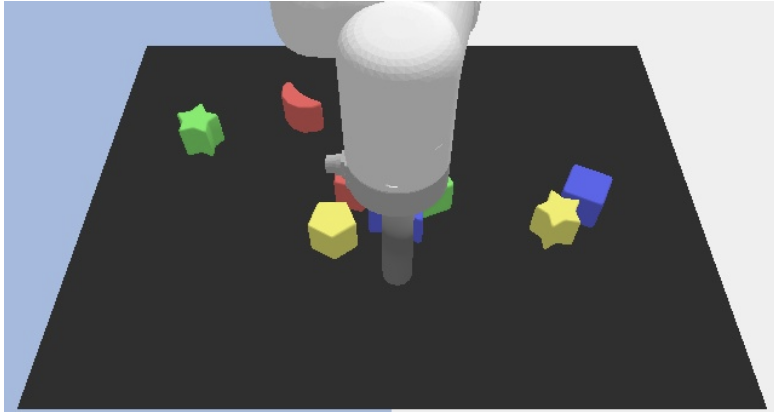

In [123]:
img

In [124]:
tokenizer.batch_decode(seq, skip_special_tokens=True)

['ANSWER: blue']

In [ ]:
idx = 10
_c = _ds[idx]

user_prompt = _c["user_prompt"]
img_path =  _c["image_path"].replace("~/scratch/data/CLEVR_v1.0/images", "/nfshomes/skarki/scratch/data/CLEVR_v1.0/images")
first_img_token_position = _c["img_token_position"]
img = Image.open(img_path).convert("RGB")

print(question)
print(answer)
print(user_prompt)

user_prompt_tokens = tokenizer(user_prompt, return_tensors="pt")
processed_image = image_processor(img, return_tensors="pt").to(0)
vit_out = vit(**processed_image)
last_hidden = vit_out.last_hidden_state
mapped_img_embeddings = vit_to_llm(last_hidden)
ins_embeddings = model.model.embed_tokens(user_prompt_tokens["input_ids"]).squeeze(1)
input_embeds = torch.cat([
  ins_embeddings[:, :first_img_token_position, :].to(0), 
  mapped_img_embeddings.to(0), 
  ins_embeddings[:, first_img_token_position + 197:, :].to(0)], dim=1
)
print(input_embeds.shape)
_gen = model.generate(
    inputs_embeds=input_embeds.half(),
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=202
)
hs = _gen.hidden_states
seq = _gen.sequences
print(seq)

In [23]:
# # idx = 120

# for idx in range(71, 81):
#     _c = dummy_ds[idx]
#     df_item = dummy_df.iloc[idx]
#     labels = _c["labels"]
#     user_prompt_len = _c["user_prompt_len"]
#     img_embeddings = _c["cls_embeddings"].to(0)
#     print("Question: ", _c["question"])
#     print("Original question (not given to the model):", df_item["original_question"])
#     print("Answer: ", _c["answer"])
    
#     qformer_embeddings = qformer.forward(img_embeddings)
#     mapped_img_embeddings = vit_to_llm(qformer_embeddings.last_hidden_state)
    
#     attn_mask = _c["attention_mask"]
#     ins_embeddings = model.model.embed_tokens(_c["input_ids"])
    
#     input_embeds = torch.cat([
#       ins_embeddings[:, :44, :].to(0),
#       mapped_img_embeddings.to(0), 
#       ins_embeddings[:, 76:, :].to(0)], dim=1
#     )
#     _gen = model.generate(
#         inputs_embeds=input_embeds.half(),
#         return_dict_in_generate=True,
#         output_scores=True,
#         output_hidden_states=True,
#         max_new_tokens=250
#     )
#     hs = _gen.hidden_states
#     seq = _gen.sequences
#     print(tokenizer.batch_decode(seq, skip_special_tokens=True))
#     print("-" * 50)

In [24]:
# import torch
# from PIL import Image
# import requests
# from transformers import Blip2Processor, Blip2Model

# device = 0
# blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model_blip = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
# model_blip.to(device)
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = blip_processor(images=image, return_tensors="pt").to(device, torch.float16)
# qformer_outputs = model_blip.get_qformer_features(**inputs)

In [25]:
# from transformers import AutoImageProcessor, ViTModel
# import torch
# from PIL import Image


# # img = Image.open("./test-img.png").convert("RGB")
# img = Image.open("./test-img.jpg")
# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# model_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# inputs = image_processor(img, return_tensors="pt")

# with torch.no_grad():
#     outputs = model_vit(**inputs)

# last_hidden_states = outputs.last_hidden_state
# last_hidden_states.shape

In [26]:
# _data = {'image_embeddings': last_hidden_states.unsqueeze(0).tolist(), 'question': "Describe the image.", "answer": "hoge"}
# _df = pd.DataFrame.from_dict(_data)
# _df.head()

In [27]:
# _ds = VQADataset(_df, tokenizer, 256)

In [28]:
# _c = _ds[0]
# labels = _c["labels"]
# user_prompt_len = _c["user_prompt_len"]
# img_embeddings = _c["cls_embeddings"].to(0)
# print("Question: ", _c["question"])
# # print("Answer: ", _c["answer"])

# qformer_embeddings = qformer.forward(img_embeddings)
# blip_embeds = qformer_embeddings.pooler_output
# mapped_img_embeddings = vit_to_llm(blip_embeds).unsqueeze(1)

# attn_mask = _c["attention_mask"]
# ins_embeddings = model.model.embed_tokens(_c["input_ids"])

# input_embeds = torch.cat([
#   ins_embeddings[:, :29, :].to(0), 
#   mapped_img_embeddings.to(0), 
#   ins_embeddings[:, 30: user_prompt_len, :].to(0)], dim=1
# )
# _gen = model.generate(
#     inputs_embeds=input_embeds.half(),
#     return_dict_in_generate=True,
#     output_scores=True,
#     output_hidden_states=True,
#     max_new_tokens=250
# )
# hs = _gen.hidden_states
# seq = _gen.sequences
# print(tokenizer.batch_decode(seq, skip_special_tokens=True)[0])
# print("-" * 50)

In [29]:
# img

In [30]:
# import torch
# from PIL import Image
# import requests
# from transformers import Blip2Processor, Blip2Model

# processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model_blip2 = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b")

# image = Image.open("./cat.jpg")
# inputs = processor(images=image, return_tensors="pt")
# qformer_outputs = model_blip2.get_qformer_features(**inputs)


In [31]:
# qformer_outputs.pooler_output.shape

In [32]:
# _c = _ds[0]
# labels = _c["labels"]
# user_prompt_len = _c["user_prompt_len"]
# img_embeddings = _c["cls_embeddings"].to(0)
# print("Question: ", _c["question"])
# # print("Answer: ", _c["answer"])

# # qformer_embeddings = qformer.forward(img_embeddings)
# # blip_embeds = qformer_embeddings.pooler_output
# mapped_img_embeddings = vit_to_llm(qformer_outputs.pooler_output.to(0)).unsqueeze(1)
# attn_mask = _c["attention_mask"]
# ins_embeddings = model.model.embed_tokens(_c["input_ids"])

# input_embeds = torch.cat([
#   ins_embeddings[:, :29, :].to(0), 
#   mapped_img_embeddings.to(0), 
#   ins_embeddings[:, 30: user_prompt_len, :].to(0)], dim=1
# )
# _gen = model.generate(
#     inputs_embeds=input_embeds.half(),
#     return_dict_in_generate=True,
#     output_scores=True,
#     output_hidden_states=True,
#     max_new_tokens=250
# )
# hs = _gen.hidden_states
# seq = _gen.sequences
# print(tokenizer.batch_decode(seq, skip_special_tokens=True)[0])
# print("-" * 50)

In [33]:
# import torch
# from PIL import Image
# import requests
# from transformers import AutoProcessor, BlipForConditionalGeneration, BlipForQuestionAnswering

# processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model_blip2 = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
# model_blip2.to(0)


In [34]:
# from PIL import Image
# import requests
# from transformers import AutoProcessor, BlipForConditionalGeneration

# processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model_blip2 = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")



In [35]:
# image = Image.open("./test-img-3.png").convert("RGB")
# text = "A picture of"

# inputs = processor(images=image, text=text, return_tensors="pt")

# outputs = model_blip2.generate(**inputs)
# processor.decode(outputs[0], skip_special_tokens=True)

In [36]:
# image

In [37]:
# from PIL import Image
# import requests
# from transformers import Blip2Processor, Blip2ForConditionalGeneration
# import torch

# processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model_blip2 = Blip2ForConditionalGeneration.from_pretrained(
#     "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
# )  # doctest: +IGNORE_RESULT


# image = Image.open("./test-img.jpg")
# prompt = "Question: What do you see in the image? Answer:"
# inputs = processor(images=image, text=prompt, return_tensors="pt").to(device=0, dtype=torch.float16)

# generated_ids = model_blip2.generate(**inputs)
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
# print(generated_text)